Run locally or <a target="_blank" href="https://colab.research.google.com/github/aalgahmi/dl_handouts/blob/main/13.encoder_decoder_models.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoder–Decoder Models

A popular architecture in deep learning in general and machine translation in particular is the Seq2Seq encoder-decoder, which looks like this:

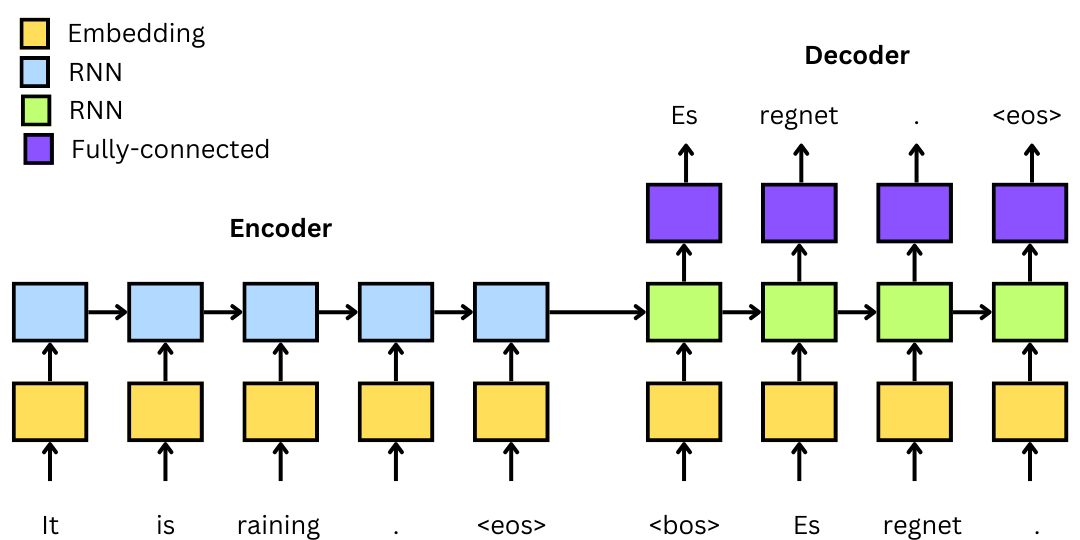

Here, the source (English) sentence is given as input to the encoder, with an optional special `<eos>` (end of sequence) token at the end. The target (German) sentence, sandwiched between `<bos>` (beginning of sequence) and `<eos>` tokens, is given to the decoder as input along with the hidden state of the encoder. The job of the decoder is to produce the translated sentence one word at a time.

In this handout, we explore three encoder-decoder NMT (Neural Machine Translation) models, where we aim to translate English sentences to German. Let's get started.

## Getting the data ready

To begin, click on the [https://www.manythings.org/anki/deu-eng.zip](https://www.manythings.org/anki/deu-eng.zip) link to download the English to German translation file into the `./datasets` folder, if you have one. You can explore other languages by downloading the appropriate file from http://www.manythings.org/anki/. 

Note that one could also use the `torchtext.datasets.Multi30k` for this task, but the dataset we are using has more data and offers more flexibility. It also allows for trying out many other languages.
    
The following code extracts the `deu.txt` file from the downloaded zip file. Feel free to adjust the paths as needed.

In [2]:
import os, zipfile

zip_filename = "./datasets/deu-eng.zip"
data_filename = "./datasets/deu.txt"

if os.path.isfile(data_filename):
    print("Loading data...", end='')
    with open(data_filename) as f:
        text = f.read()

    print("done.")
elif os.path.isfile(zip_filename):
    with zipfile.ZipFile(zip_filename, 'r') as zf:
        print("Extracting file...", end='')
        for file_info in zf.infolist():
            if file_info.filename.endswith('.txt'):
                zf.extract(file_info, './datasets')
                
        print("Loading...", end='')
        with open(data_filename) as f:
            text = f.read()
        with open(data_filename, mode="w") as f:
            f.write(text)

        print("done.")
else:
    print("You must download https://www.manythings.org/anki/deu-eng.zip into the ./dataset folder first.")

Loading data...done.


Here is an example of what a line in this file looks like:

In [3]:
for line in text.splitlines():
    print(line)
    break

Go.	Geh.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)


The dataset consists of lines with three parts separated by a tab character `\t`. We only need the first two parts; the last part should be ignored. Let's extract these parts into two separate sequences for English and German and shuffle them.

Training the models in this notebook will take a long time, especially without GPU acceleration. To speed up training at the expense of accuracy, you can use only a portion of the data. You can do this by changing the value of `data_percentage` in the cell below to a percentage of the data of your choosing.

In [4]:
data_percentage = .12
N = int(data_percentage * len(text.splitlines()))
pairs = [ line.split("\t")[:2] for line in text.splitlines()[:N] ]

np.random.shuffle(pairs) 
len(pairs)

32612

Here are a few example pairs of sentences:

In [5]:
pairs[:10]

[['Are we done?', 'War es das?'],
 ["Don't get involved.", 'Lassen Sie sich darauf nicht ein.'],
 ['He came here again.', 'Er kam wieder hierher.'],
 ['Tom is fascinated.', 'Tom ist fasziniert.'],
 ['Get to bed.', 'Gehe schlafen!'],
 ["Tom won't answer.", 'Tom wird nicht antworten.'],
 ['They hated Tom.', 'Sie konnten Tom nicht leiden.'],
 ['I teach French.', 'Ich unterrichte Französisch.'],
 ['Come quickly.', 'Komm schnell!'],
 ['Why am I so alone?', 'Warum bin ich so allein?']]

It's easier to work with this data if it's in a Pandas dataframe.

In [6]:
df_pairs = pd.DataFrame(pairs, columns=['en', 'de'])
df_pairs

,en,de
0,Are we done?,War es das?
1,Don't get involved.,Lassen Sie sich darauf nicht ein.
2,He came here again.,Er kam wieder hierher.
3,Tom is fascinated.,Tom ist fasziniert.
4,Get to bed.,Gehe schlafen!
...,...,...
32607,Stop complaining.,"Hör auf, dich zu beschweren!"
32608,I'm not ready yet.,Ich bin noch nicht bereit.
32609,Neither was true.,Keines von beiden war wahr.
32610,Tom's very sad.,Tom ist sehr traurig.


Here we have two languages: English (en) and German (de). To vectorize (numericalize) the sentences in these two languages, we first need to create a vocabulary for each language. This requires being able to tokenize the sentences first. We did this manually in the first example of the `13.rnns_for_nlp.ipynb` handout. Here, we will do it differently, utilizing more of the functions provided by `torchtext`.

To tokenize these bilingual sentences, we need the help of the [SpaCy package](https://spacy.io/usage), which is an open-source software library for advanced natural language processing. For this, we'll need to install spaCy and download its pipelines for the English and German languages. This is a one-time step. Uncomment the following commands and run them if you haven't already done so.

In [7]:
# ! pip install spacy -q

In [8]:
# ! python -m spacy download en_core_web_sm

In [9]:
# ! python -m spacy download de_core_news_sm

Next we import `spacy` and load its English and German pipelines.

In [10]:
import spacy

en = spacy.load("en_core_web_sm")
de = spacy.load("de_core_news_sm")

We can use these object to tokenize sentences. Here is an example:

In [11]:
tokens = en("This is a good morning.")

or

In [12]:
tokens = en.tokenizer("This is a good morning.")

Each of these tokens has multiple attributes. For example, the following prints each token (word) and whether it's an alphabet or considered a stop word. The token itself is obtained using `token.text`.

In [13]:
for token in tokens:
    print(token.text, token.is_alpha, token.is_stop, sep="\t")

This	True	True
is	True	True
a	True	True
good	True	False
morning	True	False
.	False	False


Similarly, here is a tokenized German sentence:

In [14]:
[token.text for token in de("Was ist dein Plan für heute?")]

['Was', 'ist', 'dein', 'Plan', 'für', 'heute', '?']

Next, we tokenize all the sentences in the above `df_pairs` dataframe. To make this work for both languages, we create a Python closure called `tokenize` and use it with the `map` function. This may take a short while to run.

In [15]:
def tokenize(tokenizer):
    def do(text):
        return [token.text for token in tokenizer(text.lower())]

    return do
    
en_tokens = list(map(tokenize(en), df_pairs['en']))
de_tokens = list(map(tokenize(de), df_pairs['de']))

The results, `en_tokens` and `de_tokens`, are lists whose items are tokenized sentences. Below are the top 5 tokenized sentences of each:

In [16]:
en_tokens[:5]

[['are', 'we', 'done', '?'],
 ['do', "n't", 'get', 'involved', '.'],
 ['he', 'came', 'here', 'again', '.'],
 ['tom', 'is', 'fascinated', '.'],
 ['get', 'to', 'bed', '.']]

In [17]:
de_tokens[:5]

[['war', 'es', 'das', '?'],
 ['lassen', 'sie', 'sich', 'darauf', 'nicht', 'ein', '.'],
 ['er', 'kam', 'wieder', 'hierher', '.'],
 ['tom', 'ist', 'fasziniert', '.'],
 ['gehe', 'schlafen', '!']]

We are now ready to build the vocabularies using the `en_tokens` and `de_tokens` lists. For this, we'll use `torchtext.vocab.build_vocab_from_iterator`, with these lists of tokenized sentences as the iterators. We'll set it up so that tokens that do not appear in the dataset more than once (`min_freq=2`) are ignored. Additionally, we need to add four special tokens:
* `<pad>` for padding
* `<unk>` for unknown tokens
* `<bos>` to mark the beginning of a sentence
* `<eos>` to mark the end of a sentence

These last two tokens are needed for encoder-decoder models, as shown in the figure above. Finally, we'll set the default token to unknown (1 or `<unk>`) for both vocabularies.

In [18]:
en_vocab = torchtext.vocab.build_vocab_from_iterator(
    en_tokens, min_freq=2,
    specials=["<pad>", "<unk>", "<bos>", "<eos>"]
)
en_vocab.set_default_index(1)

de_vocab = torchtext.vocab.build_vocab_from_iterator(
    de_tokens, min_freq=2,
    specials=["<pad>", "<unk>", "<bos>", "<eos>"]
)
de_vocab.set_default_index(1)

print('en_vocab size:', len(en_vocab)) 
print('de_vocab size:', len(de_vocab)) 

en_vocab size: 3164
de_vocab size: 4337


As a sanity check, here are the top 20 tokens of both vocabularies:

In [19]:
en_vocab.get_itos()[:20]

['<pad>',
 '<unk>',
 '<bos>',
 '<eos>',
 '.',
 'i',
 'tom',
 '?',
 'you',
 'is',
 'it',
 "'s",
 'a',
 "n't",
 'do',
 'we',
 "'m",
 'that',
 'was',
 'he']

In [20]:
de_vocab.get_itos()[:20]

['<pad>',
 '<unk>',
 '<bos>',
 '<eos>',
 '.',
 'ich',
 'tom',
 'ist',
 '?',
 'sie',
 'das',
 '!',
 'es',
 'nicht',
 'du',
 'wir',
 'hat',
 'bin',
 'er',
 'habe']

The reason why we need vocabularies is so we can vectorize sentences by converting them to numeric values. These values correspond to the indices of their tokens in these vocabularies. Using these vocabularies, we can vectorize any tokenized sentence. Here is an example:

In [21]:
tokenized_de_sentence = de_tokens[99]
tokenized_de_sentence

['ich', 'korrigierte', 'mich', '.']

Let's vectorize it using the `lookup_indices` method of the vocabulary.

In [22]:
vectorized_de_sentence = de_vocab.lookup_indices(tokenized_de_sentence)
vectorized_de_sentence

[5, 3749, 25, 4]

Note that the opposite (converting numeric indices to tokens) can be done using the `lookup_tokens` method of the vocabulary:

In [23]:
de_vocab.lookup_tokens(vectorized_de_sentence)

['ich', 'korrigierte', 'mich', '.']

With that, we are ready to vectorize the whole dataset. Here is a `vectorize` closure used with the `map` function to achieve that. As we do so, we will surround each sentence, whether in English or German, between the `<bos>` and `<eos>` special tokens that we added to our vocabularies earlier. Additionally, we will convert the vectorized sentences into PyTorch tensors.

In [24]:
def vectorize(vocab):
    def do(tokens):
        return torch.tensor(vocab.lookup_indices(['<bos>'] + tokens + ['<eos>']))
    return do

en_vectorized = list(map(vectorize(en_vocab), en_tokens))
de_vectorized = list(map(vectorize(de_vocab), de_tokens))

Here are the top 5 vectorized sentences in both languages:

In [25]:
en_vectorized[:5]

[tensor([  2,  25,  15, 242,   7,   3]),
 tensor([   2,   14,   13,   48, 1372,    4,    3]),
 tensor([  2,  19, 145,  35, 102,   4,   3]),
 tensor([   2,    6,    9, 1793,    4,    3]),
 tensor([  2,  48,  24, 213,   4,   3])]

In [26]:
de_vectorized[:5]

[tensor([ 2, 22, 12, 10,  8,  3]),
 tensor([  2, 180,   9,  36, 813,  13,  20,   4,   3]),
 tensor([  2,  18, 142, 126, 477,   4,   3]),
 tensor([   2,    6,    7, 1219,    4,    3]),
 tensor([  2, 164, 293,  11,   3])]

Notice how every tensor starts with `2` (for `<bos>`) and ends with `3` (for `<eos>`).

Next, we put all these vectorized data into a dataset. Here is a simple class that does that by having each vectorized English sentence next to its corresponding vectorized German sentence. This is where we apply padding using the `nn.utils.rnn.pad_sequence` function.

In [27]:
from torch.utils.data import Dataset, DataLoader, random_split

class En2DeDataset(Dataset):
    def __init__(self, en_vectorized, de_vectorized):
        self.en = nn.utils.rnn.pad_sequence(en_vectorized, batch_first=True)
        self.de = nn.utils.rnn.pad_sequence(de_vectorized, batch_first=True)

    def __len__(self):
        return len(self.en)

    def __getitem__(self, idx):
        return self.en[idx], self.de[idx]

Using this class, we can create a dataset and split it into training and testing sets.

In [28]:
ds_train, ds_test = random_split(
    En2DeDataset(en_vectorized, de_vectorized), [.85, .15]
)

len(ds_train), len(ds_test)

(27721, 4891)

And to be sure things look good, here is the first sentence pair in the training dataset:

In [29]:
ds_train[0][0], ds_train[0][1]

(tensor([   2, 1197,    1,  352,    4,    3,    0,    0,    0,    0]),
 tensor([   2, 1478,  341,  371,    4,    3,    0,    0,    0,    0,    0,    0,
            0,    0]))

Finally we create the training and testing data loaders. We'll use a batch size of 64.

In [30]:
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=64, shuffle=False)

len(dl_train), len(dl_test)

(434, 77)

And again, let's be sure the first sentences of the first batch look good:

In [31]:
next(iter(dl_train))[0][:5]

tensor([[   2,    6,   11,  842,    4,    3,    0,    0,    0,    0],
        [   2,   28,    6,   32,    7,    3,    0,    0,    0,    0],
        [   2,    5,  184,   20, 1995,    4,    3,    0,    0,    0],
        [   2,  120,  126,  291,   21,    4,    3,    0,    0,    0],
        [   2,    5,   63,   55,  154,    4,    3,    0,    0,    0]])

In [32]:
next(iter(dl_train))[1][:5]

tensor([[   2,   15,   31,   38, 1786,    4,    3,    0,    0,    0,    0,    0,
            0,    0],
        [   2,   18,   54, 1594,  269,    4,    3,    0,    0,    0,    0,    0,
            0,    0],
        [   2,   42,  270,  134,   63,   11,    3,    0,    0,    0,    0,    0,
            0,    0],
        [   2,   18,  414,   21,   91,    4,    3,    0,    0,    0,    0,    0,
            0,    0],
        [   2,    5,   81,   12,   97,   13,    4,    3,    0,    0,    0,    0,
            0,    0]])

Notice how the German sentences in general are longer and incur more padding, which you can see with all the zeroes at the end.

## A simple encoder-decoder model without attention

We are now ready to build the first model. We'll create two PyTorch modules (layers): an encoder and a decoder. We will then bring them together in a Lightning module, where most of the work is done. This will be a simplified version of the implementation in [this paper](https://arxiv.org/abs/1409.3215), using GRU instead of LSTM, and with fewer hidden units and recurrent layers. The figure below illustrates all the main components of this model and how these pieces are connected.

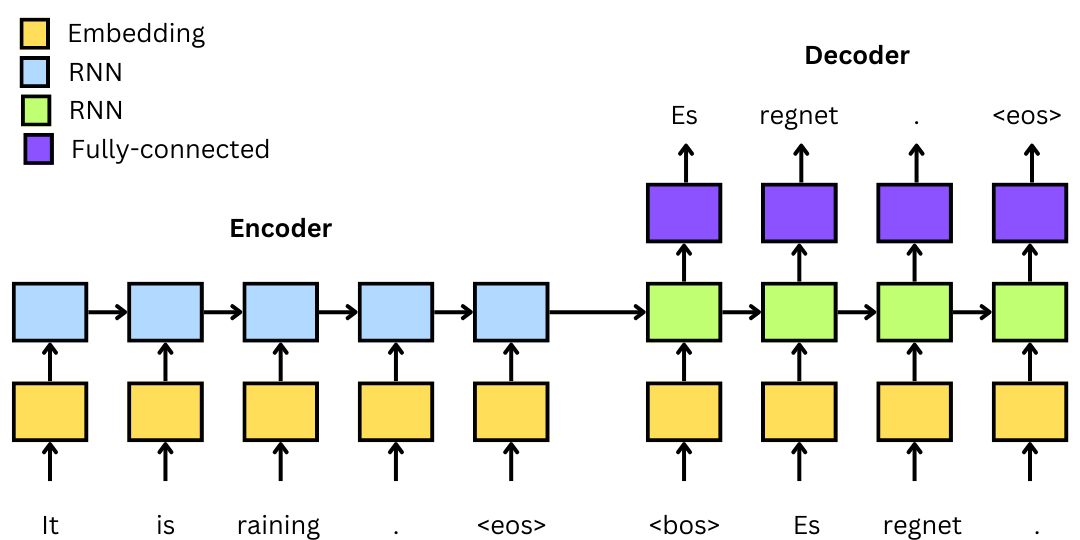

Here is the encoder. It has its own embedding layer and uses dropout before the embedded output is fed as input to the GRU module. For the GRU module, we are using `batch_first=True`, which means the input and output of this module will have the `[batch_size, seq_length, embed_size]` and `[batch_size, seq_length, hidden_size]` shapes, respectively. However, it's important to remember that this option does not apply to the hidden states (including cell states if using LSTM), which will always be in the `[seq_length, batch_size, hidden_size]` shape. When in doubt, refer to the PyTorch documentation.

In [33]:
class SimpleEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, dropout=.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        _, hidden = self.gru(embedded)
        
        return hidden

And here is the decoder. Again, it has its own embedding layer. There is also a fully-connected (Linear) layer at the end that maps the output of the GRU layer to logits.

In [34]:
class SimpleDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, dropout=.2):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded, hidden)
        logits = self.fc(output.squeeze())
        return logits, hidden

Finally, here is the main module. We'll use Lightning for this. This is where we bring together the encoder and decoder modules. The code is self-explanatory, but pay attention to both the `forward` and `training_step` methods. 

The `forward` method calls the encoder on the source (English) sentence and obtains its final hidden state. This state will be input for the next decoder step. Instead of calling the decoder just once, we unroll it one target (German) token at a time. During training, the input to each step comes from the target sequence. This is called **teacher forcing**. During inference (evaluation), the output of the previous step is passed as input to the next decoder step. All the outputs from all the decoder steps are saved and returned at the end.

The `training_step` calculates the loss by comparing the decoder's outputs against the target tokens, ignoring the first token on each sequence. This is akin to multiclass classification with a large number of possible classes (equal to the size of the target vocabulary), and therefore the loss is computed using cross-entropy with `ignore_index=0` to minimize the effect of padding on the calculated loss. 

For the optimizer, we use Adam. To keep things simple and uncluttered, I'm not using a validation step here. You can add that yourself as an exercise.

In [35]:
import lightning as L

class SimpleEncoderDecoder(L.LightningModule):
    def __init__(self, src_vacab_size, tgt_vacab_size, embed_size, hidden_size, lr=0.001):
        super().__init__()
        
        self.lr = lr
        self.tgt_vacab_size = tgt_vacab_size
        
        self.encoder = SimpleEncoder(src_vacab_size, embed_size, hidden_size, dropout=.2)
        self.decoder = SimpleDecoder(tgt_vacab_size, embed_size, hidden_size, dropout=.2)
        
        self.tgt_vacab_size = tgt_vacab_size
        
    def forward(self, src, tgt):
        batch_size = tgt.size(0)
        tgt_length = tgt.size(1)

        hidden = self.encoder(src)
        input = tgt[:, 0]
        
        outputs = torch.zeros(batch_size, tgt_length, self.tgt_vacab_size).to(device)
        for t in range(1, tgt_length):
            logits, hidden = self.decoder(input, hidden)

            outputs[:, t, :] = logits
            pred = logits.argmax(1)

            input = tgt[:, t] if self.training else pred # Teacher forcing

        return outputs

    def training_step(self, batch, batch_idx):
        src = batch[0]
        tgt = batch[1].long()

        output = self(src, tgt)
        output_dim = output.shape[-1]
        output = output[:, 1:, :].reshape(-1, self.tgt_vacab_size)

        tgt = tgt[:, 1:].reshape(-1)

        loss = F.cross_entropy(output, tgt, ignore_index=0)
        self.log("loss", loss, prog_bar=True)
        
        return loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Let's create a model and summarize it:

In [36]:
from torchinfo import summary

simple_model = SimpleEncoderDecoder(
    src_vacab_size=len(en_vocab), 
    tgt_vacab_size=len(de_vocab), 
    embed_size=128, 
    hidden_size=256
)

summary(simple_model)

Layer (type:depth-idx)                   Param #
SimpleEncoderDecoder                     --
├─SimpleEncoder: 1-1                     --
│    └─Embedding: 2-1                    404,992
│    └─GRU: 2-2                          296,448
│    └─Dropout: 2-3                      --
├─SimpleDecoder: 1-2                     --
│    └─Embedding: 2-4                    555,136
│    └─GRU: 2-5                          296,448
│    └─Linear: 2-6                       1,114,609
│    └─Dropout: 2-7                      --
Total params: 2,667,633
Trainable params: 2,667,633
Non-trainable params: 0

We are ready to train it. We'll use the Lightning trainer for that, with a CSV logger so we can easily plot the training curve at the end.

In [37]:
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="simple_enc_dec")

trainer = L.Trainer(max_epochs=10, logger=logger)
trainer.fit(simple_model, train_dataloaders=dl_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params
------------------------------------------
0 | encoder | SimpleEncoder | 701 K 
1 | decoder | SimpleDecoder | 2.0 M 
------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.671    Total estimated model params size (MB)
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Let's plot the learning curve.

<Axes: title={'center': 'Training Curve'}>

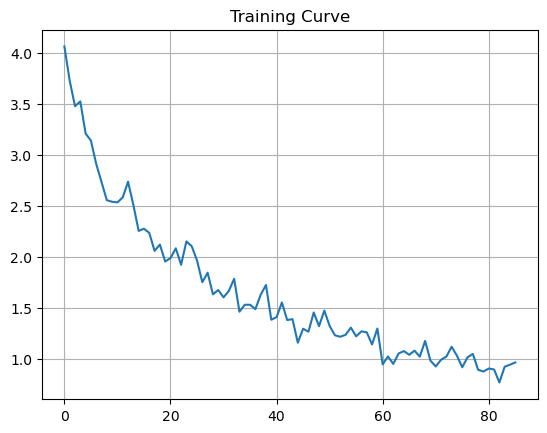

In [38]:
hist = pd.read_csv(f"./logs/simple_enc_dec/version_{len(os.listdir('./logs/simple_enc_dec/')) - 1}/metrics.csv")
hist['loss'].dropna().plot(grid=True, title="Training Curve")

Next, we test this simple translation model by asking it to translate a few given English sentences. The fact that this model takes two (source and target) inputs makes this more complex than we are used to. Obviously, we have the source (English) sentence. We can feed it as input to the encoder, but where are we going to get the decoder input from? Well, as mentioned before, we will unfold the decoder one step at a time with the output of one step serving as the input to the next step. This means we generate the translation one word at a time. This is illustrated in the following figure.

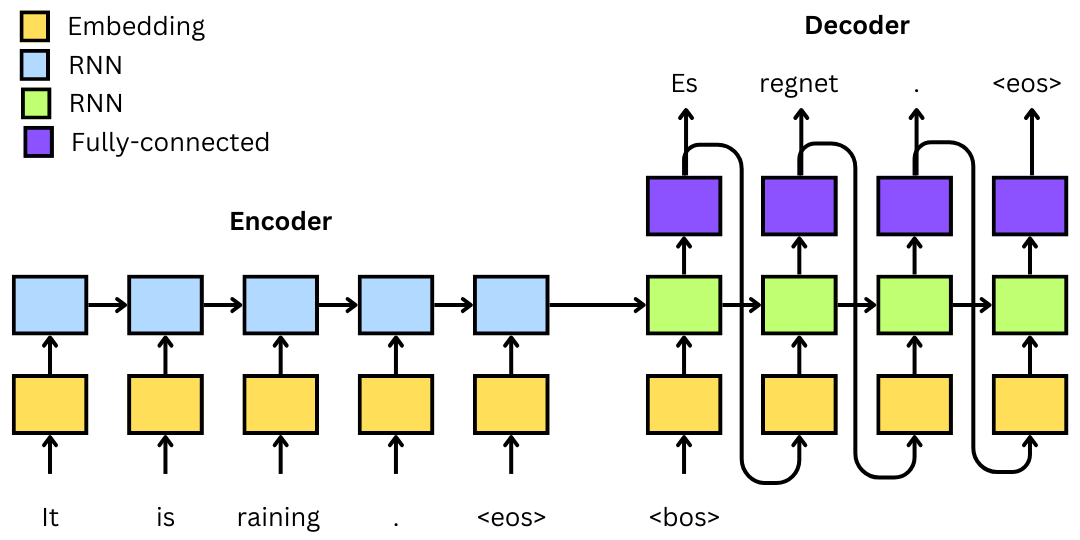

Let's put this together in a function. As you can see, this is a greedy algorithm picking the best word every time. It will stop when the `<eos>` symbol is reached or after a certain maximum number of iterations. We'll make this function return both the translated tokens and the source tokens.

In [39]:
def translate_v1(sentence, model,
    en_tokenizer, en_vocab, de_tokenizer, de_vocab):
    model.eval()
    with torch.no_grad():
        tokens = [token.text for token in en_tokenizer(sentence.lower())]
        
        tokens = ['<bos>'] + tokens + ['<eos>']
        ids = en_vocab.lookup_indices(tokens)

        tensor = torch.LongTensor(ids).unsqueeze(0)
        
        hidden = model.encoder(tensor)
        inputs = de_vocab.lookup_indices(['<bos>'])
        
        max_length=len(ids) + 5
        for _ in range(max_length):
            inputs_tensor = torch.LongTensor([inputs[-1]])

            output, hidden = model.decoder(inputs_tensor, hidden)

            pred = output.argmax(-1).item()
            inputs.append(pred)
            if pred == de_vocab['<eos>']: break
                
        de_tokens = de_vocab.lookup_tokens(inputs)
        
    return de_tokens, tokens

Here are a few example translations:

In [40]:
translate_v1("Do you need gloves?", simple_model, en, en_vocab, de, de_vocab)[0]

['<bos>', 'brauchen', 'sie', 'mitfahren', '?', '<eos>']

In [41]:
translate_v1("i said I'd get it.", simple_model, en, en_vocab, de, de_vocab)[0]

['<bos>', 'ich', 'sagte', ',', 'ich', 'würde', 'es', 'tun', '.', '<eos>']

In [42]:
translate_v1("I am going to the beach to play soccer", simple_model, en, en_vocab, de, de_vocab)[0]

['<bos>', 'hallo', ',', 'ich', 'bin', '<unk>', '.', '<eos>']

These translations are not the best, and it is obvious that the model struggles a lot with translating longer sentences. The quality of the translations can be improved with a more powerful model and more data (remember, we are only using 12% of the available data). Instead of the greedy translation approach above, the quality of the translation will improve significantly if we use beam search, as discussed in class.

## An encoder-decoder model with attention

When the attention mechanism was proposed in 2014 by Bahdanau et al., it was proposed as a way to improve RNN-based decoder-encoder models such as the one we just tested. Here is how attention is used in such a model.

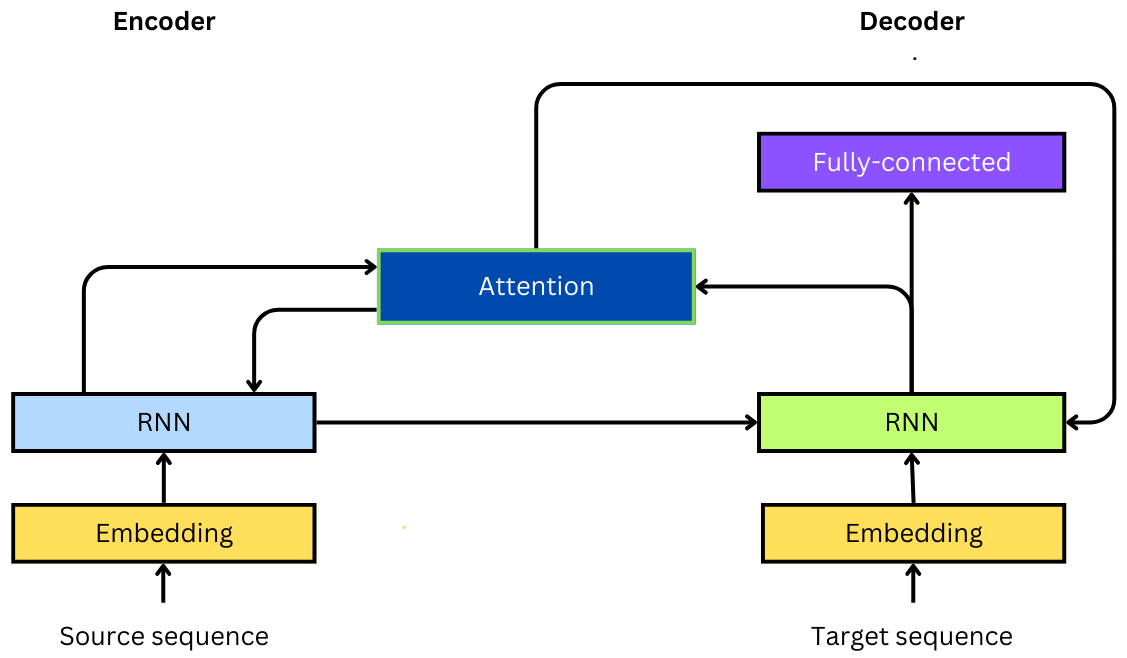


Bahdanau attention computes the attention scores by comparing the decoder hidden state (query) $h_t$ at time step $t$ with each encoder hidden state $h_i$ (keys), where $i$ represents the position in the input sequence. The attention score $\omega_{ti}$ is computed as follows:

$$\omega_{ti} = v_a^T \text{tanh}(W_a h_i + U_a h_t)$$

where:
- $W_a$ and $U_a$ are weight matrices.
- $v_a$ is a learnable parameter vector.

The attention weights $\alpha_{ti}$ are calculated using the softmax function:

$$ \alpha_{ti} = \frac{\exp(\omega_{ti})}{\sum_{j=1}^{T_x} \exp(\omega_{tj})} $$

where $ T_x $ is the length of the input sequence.

Once we have the attention weights, the context vector $c_t $ is computed as the weighted sum of the encoder hidden states:

$$ c_t = \sum_{i=1}^{T_x} \alpha_{ti} h_i $$

Below is a module (layer) that implements this attention technique:

In [43]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        """ Given query: [batch_size, 1, hidden_size]
                   keys: [batch_size, seq_length, hidden_size]
        """
        scores = self.va(torch.tanh(self.Wa(keys) + self.Ua(query))) # [batch_size, seq_length, 1]
        scores = scores.squeeze(2).unsqueeze(1) # [batch_size, 1, seq_length]

        weights = F.softmax(scores, dim=-1) # [batch_size, 1, seq_length]
        
        context = torch.bmm(weights, keys) # [batch_size, 1, hidden_size]

        return context, weights

Next is the encoder module. This is the same as before except that it now returns both its output and hidden state.

In [44]:
class AttnEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, dropout=.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, hidden = self.gru(embedded)
        
        return output, hidden

And here is the decoder. This is where the attention module is added. Notice how the hidden state of the decoder serves as the query for the attention layer and that the context vector returned from the attention layer is concatenated with the embedded input of the decoder and is used to predict the next token in the output sequence.

In [45]:
class AttnDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, dropout=.5):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(hidden_size)
        self.gru = nn.GRU(embed_size + hidden_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2) 
        context, attn_weights = self.attention(query, encoder_outputs)
        
        embedded_with_attn = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(embedded_with_attn, hidden)
        logits = self.fc(output.squeeze())
        
        return logits, hidden, attn_weights

Finally, here is the attention-based encoder-decoder model. It's mostly the same as before with the following remarks:

* We now have the encoder outputs, which are passed to the decoder to drive the attention mechanism.
* The decoder returns the concatenated attention weights, but that is only in case we want to visualize them, which we will do at the end of this section.

In [46]:
class AttnEncoderDecoder(L.LightningModule):
    def __init__(self, src_vacab_size, tgt_vacab_size, embed_size, hidden_size, lr=0.001):
        super().__init__()
        
        self.lr = lr
        self.tgt_vacab_size = tgt_vacab_size
        
        self.encoder = AttnEncoder(src_vacab_size, embed_size, hidden_size, dropout=.3)
        self.decoder = AttnDecoder(tgt_vacab_size, embed_size, hidden_size, dropout=.3)
        
        self.tgt_vacab_size = tgt_vacab_size
        
    def forward(self, src, tgt):
        batch_size = tgt.size(0)
        tgt_length = tgt.size(1)

        encoder_outputs, hidden = self.encoder(src)

        input = tgt[:, 0]
        attentions = []
        outputs = torch.zeros(batch_size, tgt_length, self.tgt_vacab_size).to(device)
        for t in range(1, tgt_length):
            logits, hidden, attn_weights = self.decoder(input, hidden, encoder_outputs)

            attentions.append(attn_weights)
            
            outputs[:, t, :] = logits
            pred = logits.argmax(1)

            input = tgt[:, t] if self.training else pred # Teacher forcing

        return outputs, torch.cat(attentions, dim=1)

    def training_step(self, batch, batch_idx):
        src = batch[0]
        tgt = batch[1].long()

        output, _ = self(src, tgt)
        output_dim = output.shape[-1]
        output = output[:, 1:, :].reshape(-1, self.tgt_vacab_size)

        tgt = tgt[:, 1:].reshape(-1)

        loss = F.cross_entropy(output, tgt, ignore_index=0)
        self.log("loss", loss, prog_bar=True)
        
        return loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Let's build and summarize model of this class:

In [47]:
attn_model = AttnEncoderDecoder(
    src_vacab_size=len(en_vocab), 
    tgt_vacab_size=len(de_vocab), 
    embed_size=128, 
    hidden_size=256
)

summary(attn_model)

Layer (type:depth-idx)                   Param #
AttnEncoderDecoder                       --
├─AttnEncoder: 1-1                       --
│    └─Embedding: 2-1                    404,992
│    └─GRU: 2-2                          296,448
│    └─Dropout: 2-3                      --
├─AttnDecoder: 1-2                       --
│    └─Embedding: 2-4                    555,136
│    └─Attention: 2-5                    --
│    │    └─Linear: 3-1                  65,792
│    │    └─Linear: 3-2                  65,792
│    │    └─Linear: 3-3                  257
│    └─GRU: 2-6                          493,056
│    └─Linear: 2-7                       1,114,609
│    └─Dropout: 2-8                      --
Total params: 2,996,082
Trainable params: 2,996,082
Non-trainable params: 0

Next, we train the model:

In [48]:
logger = CSVLogger("logs", name="attn_enc_dec")

trainer = L.Trainer(max_epochs=10, logger=logger)
trainer.fit(attn_model, train_dataloaders=dl_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/attn_enc_dec

  | Name    | Type        | Params
----------------------------------------
0 | encoder | AttnEncoder | 701 K 
1 | decoder | AttnDecoder | 2.3 M 
----------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.984    Total estimated model params size (MB)
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


And plot the learning curve, just like before.

<Axes: title={'center': 'Training Curve'}>

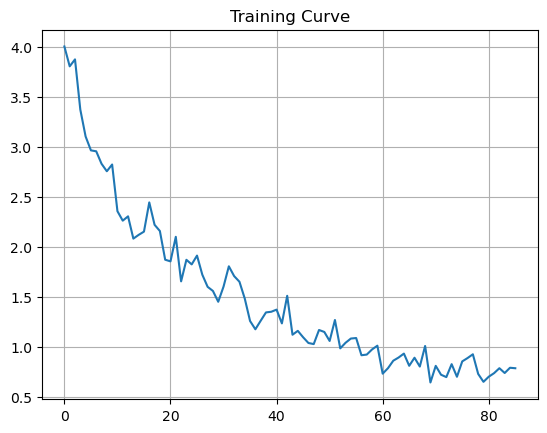

In [49]:
hist = pd.read_csv(f"./logs/attn_enc_dec/version_{len(os.listdir('./logs/attn_enc_dec/')) - 1}/metrics.csv")
hist['loss'].dropna().plot(grid=True, title="Training Curve")

For inference, we'll need to create a new slightly modified version of the `translate_v1` function from before. We'll make this function return the concatenated attention weights in addition to the target and source tokens.

In [50]:
def translate_v2(sentence, model,
    en_tokenizer, en_vocab, de_tokenizer, de_vocab):
    model.eval()
    with torch.no_grad():
        tokens = [token.text for token in en_tokenizer(sentence.lower())]
        
        tokens = ['<bos>'] + tokens + ['<eos>']
        ids = en_vocab.lookup_indices(tokens)

        tensor = torch.LongTensor(ids).unsqueeze(0)
        
        outputs, hidden = model.encoder(tensor)
        inputs = de_vocab.lookup_indices(['<bos>'])
        attentions = []

        max_length=len(ids) + 5
        for _ in range(max_length):
            inputs_tensor = torch.LongTensor([inputs[-1]])

            output, hidden, attn = model.decoder(inputs_tensor, hidden, outputs)
            attentions.append(attn)
            pred = output.argmax(-1).item()
            inputs.append(pred)
            if pred == de_vocab['<eos>']: break
                
        de_tokens = de_vocab.lookup_tokens(inputs)
        
    return de_tokens, tokens, torch.cat(attentions, dim=1)

Here are a few example translations:

In [51]:
t1, s1, a1 = translate_v2("Do you need gloves?", attn_model, en, en_vocab, de, de_vocab)
t1

['<bos>', 'brauchst', 'du', 'handschuhe', '?', '<eos>']

In [52]:
t2, s2, a2 = translate_v2("i said I'd get it.", attn_model, en, en_vocab, de, de_vocab)
t2

['<bos>', 'ich', 'sagte', ',', 'ich', 'würde', 'es', 'bekommen', '.', '<eos>']

In [53]:
t3, s3, a3 = translate_v2("I am going to the beach to play soccer", attn_model, en, en_vocab, de, de_vocab)
t3

['<bos>', 'gehe', 'ich', 'ins', 'bett', '!', '<eos>']

Again, these translations are not perfect and can be improved using the techniques we discussed above.

As a last step, let's visualize the attention weights from the above sentences. For that, we need to create a function.

In [54]:
import matplotlib.ticker as ticker

def visualize_attn_weights(src_tokens, tgt_tokens, attn_weights, cmap="summer", ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    ax.matshow(attn_weights.cpu(), cmap=cmap)

    ax.xaxis.set_ticks(range(len(src_tokens[1:-1])))
    ax.xaxis.set_ticklabels(src_tokens[1:-1], rotation=90)

    ax.yaxis.set_ticks(range(len(tgt_tokens[1:])))
    ax.yaxis.set_ticklabels(tgt_tokens[1:])

Let's call this function on the output of sentences above.

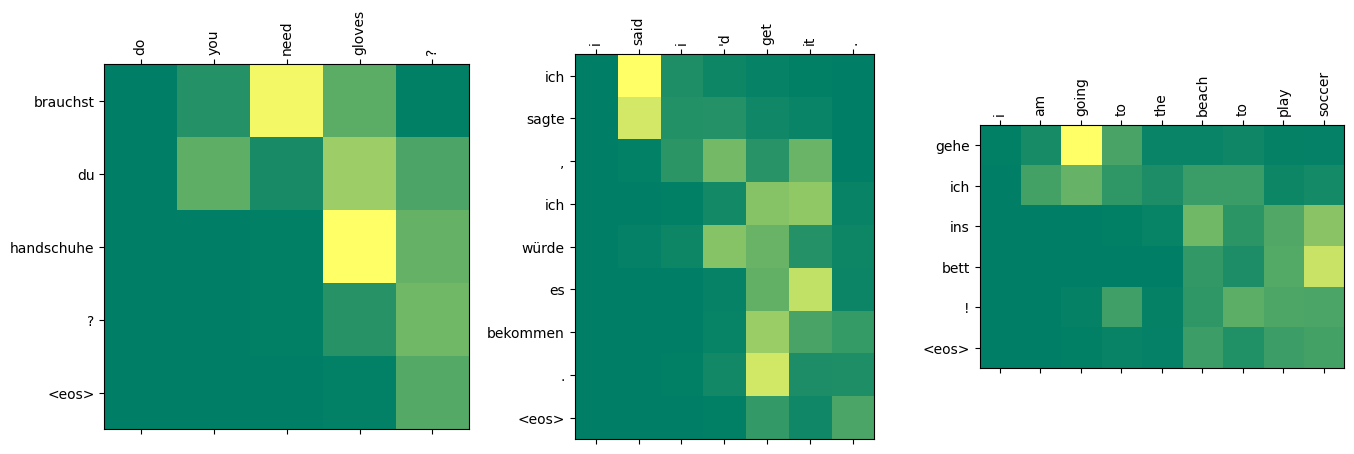

In [55]:
t, s, a = [t1, t2, t3], [s1, s2, s3], [a1, a2, a3],

fig = plt.figure(figsize=(16,5))
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    visualize_attn_weights(s[i], t[i], a[i][0, :len(t[i]), 1:-1], ax=ax)

## The Transformer architecture

The influential paper 'Attention Is All You Need' by Vaswani et al. (2017) proposed the first Transformer architecture, which completely replaced RNN layers with attention layers for both the encoder and decoder. Here is what the original Transformer model looks like:

We will not attempt to implement the Transformer model from scratch here. The 'Annotated Transformer' handout by Austin Huang, et al. of Harvard, does that very well. Unless you are conducting research, it is unlikely that you will need to build transformers from scratch. Instead, you will likely use a platform such as HuggingFace, which has made a business out of implementing transformers and creating an ecosystem for them.

This section, however, demonstrates how to use the `nn.Transformer` module that comes with PyTorch for the English-to-German translation problem we have been working on in this handout. Let's get started.

First, we create a function that provides us with the necessary masks:

In [56]:
def causal_mask(size):
    m = torch.triu(torch.ones(size, size)).transpose(0, 1)
    return m.masked_fill(m == 0., float('-inf')).masked_fill(m == 1, float(0.0))
    
def create_masks(src, tgt, pad_idx=0):
    src_len, tgt_len = src.size(1), tgt.size(1)
    
    tgt_mask = causal_mask(tgt_len).to(device)
    
    src_mask = torch.zeros((src_len, src_len)).float().to(device)
    src_pad_mask = (src == pad_idx).float().to(device)
    tgt_pad_mask = (tgt == pad_idx).float().to(device)
    
    return src_mask, src_pad_mask, tgt_mask, tgt_pad_mask

There are four masks here: two for the encoder and two for the decoder. These masks are needed by the `nn.Transformer` module to pass to its self-attention and cross-attention layers. Here is what these masks look like for the first 5 sentences of the first training batch.

In [57]:
src, tgt = next(iter(dl_train))
create_masks(src[:5], tgt[:5])

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]]),
 tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., -inf, -inf, -inf, -inf, -

As you can see, the first mask (source mask) consists of all zeros. The second mask indicates which source tokens are padding and which are not. On the decoder side, the third mask is used to apply a **causal mask** to the multi-head attention mechanism at the bottom of the decoder. This mask is not for padding; rather, it prevents the decoder from seeing tokens beyond what it is currently processing, as allowing it to do so would be considered cheating. This causal mask was created using the handy `torch.triu` function, which sets the bottom triangular part of the matrix to 0 and returns the upper part. Finally, the fourth mask is for target padding.

Next, before building the model, we need to have a plan for how to encode word order. The attention layers don't care much about sequence order. If order is important (which it is for sequential data such as this), we need to add it outside of the `nn.Transformer` module. The original transformer added it to word embeddings on both the encoder and decoder sides. It uses the following **positional encoding** for that.

$$PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})$$

where $pos$ is the position and $i$ is the dimension.

Here is a module named `PositionalEncoding` that accomplishes this, borrowed from the aforementioned Annotated Transformer handout.

In [58]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        
        return self.dropout(x)

We now have everything we need to create our simple transformer model. Here is a Lightning module for that:

In [59]:
class SimpleTransformer(L.LightningModule):
    def __init__(self, num_encoder_layers, num_decoder_layers, embed_size, nhead,
        src_vocab_size, tgt_vocab_size, dim_feedforward = 512, dropout = 0.1):
        
        super().__init__()
        self.tgt_vocab_size = tgt_vocab_size
        
        self.transformer = nn.Transformer(
            d_model=embed_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(embed_size, tgt_vocab_size)
        self.src_tok_emb = nn.Embedding(src_vocab_size, embed_size)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=dropout)
        
    def forward(self, src, trg, src_mask, tgt_mask, src_pad_mask, tgt_pad_mask, mem_key_pad_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_pad_mask, tgt_pad_mask, mem_key_pad_mask)
        
        return self.fc(outs)
        
    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)
        
    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

    def training_step(self, batch, batch_idx):
        src, tgt = batch
        tgt_input = tgt[:, :-1]
        
        src_mask, src_pad_mask, tgt_mask, tgt_pad_mask = create_masks(src, tgt_input)
        logits = self(
            src, tgt_input,  
            src_mask, tgt_mask,
            src_pad_mask, tgt_pad_mask, src_pad_mask
        )
        
        tgt_out = tgt[:, 1:]
        loss = F.cross_entropy(
            logits.view(-1, self.tgt_vocab_size), 
            tgt_out.contiguous().view(-1), ignore_index=0
        )

        self.log("loss", loss, prog_bar=True)
        
        return loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)


As you can see, two embedding layers and two positional encoding layers were added to the `nn.Transformer` module. There is also a linear layer `self.fc` that generates the logits from the output produced by the transformer.

Let's create and summarize a simple transformer model:

In [60]:
transformer_model = SimpleTransformer(
    num_encoder_layers=3, 
    num_decoder_layers=3, 
    embed_size=192, # Choose a number that is divisible by nhead.
    nhead=6, 
    src_vocab_size=len(en_vocab), 
    tgt_vocab_size=len(de_vocab), 
    dim_feedforward= 256
)

summary(transformer_model)

Layer (type:depth-idx)                                                 Param #
SimpleTransformer                                                      --
├─Transformer: 1-1                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            743,232
│    │    └─LayerNorm: 3-2                                             384
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            1,189,056
│    │    └─LayerNorm: 3-4                                             384
├─Linear: 1-2                                                          837,041
├─Embedding: 1-3                                                       607,488
├─Embedding: 1-4                                                       832,704
├─PositionalEncoding: 1-5                                              --
│   

Let's also print this model to see what is inside it.

In [61]:
transformer_model

SimpleTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
          )
          (linear1): Linear(in_features=192, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=192, bias=True)
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttenti

We are now ready to train this model.

In [62]:
logger = CSVLogger("logs", name="simple_transformer")

trainer = L.Trainer(max_epochs=20, logger=logger)
trainer.fit(transformer_model, train_dataloaders=dl_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/simple_transformer

  | Name                | Type               | Params
-----------------------------------------------------------
0 | transformer         | Transformer        | 1.9 M 
1 | fc                  | Linear             | 837 K 
2 | src_tok_emb         | Embedding          | 607 K 
3 | tgt_tok_emb         | Embedding          | 832 K 
4 | positional_encoding | PositionalEncoding | 0     
-----------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.841    Total estimated model params size (MB)
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


As before, here is the training curve:

<Axes: title={'center': 'Training Curve'}>

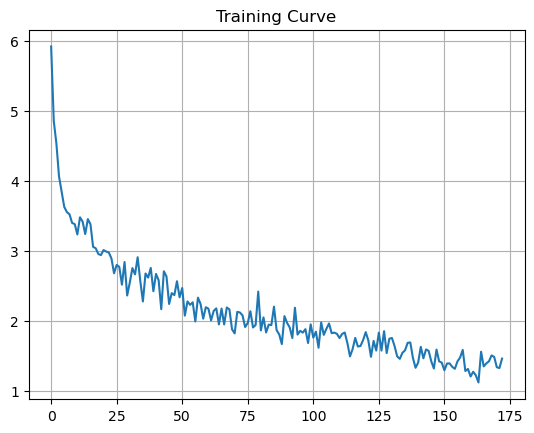

In [63]:
hist = pd.read_csv(f"./logs/simple_transformer/version_{len(os.listdir('./logs/simple_transformer/')) - 1}/metrics.csv")
hist['loss'].dropna().plot(grid=True, title="Training Curve")

To test this model, we'll need to create another version of our translate function. We will also need a function that takes a sentence, tokenizes it, and vectorizes it, all in one step. Let's call it `numericalize`.

In [64]:
def numericalize(str, tokenizer, vocab):
    tokens = [token.text for token in tokenizer(str.lower())]
    return torch.tensor(vocab.lookup_indices(['<bos>'] + tokens + ['<eos>']))

numericalize('Is this working?', en, en_vocab)

tensor([  2,   9,  23, 319,   7,   3])

Finally, here is our updated translate function. This version includes modifications to accommodate the transformer model we just trained.

In [65]:
def translate_v3(sentence, model, en_tokenizer, en_vocab, de_tokenizer, de_vocab):
    model.eval()
    src = numericalize(sentence, en, en_vocab).view(1, -1)
    num_tokens = src.size(1)
    bos_idx = 2
    src_mask = torch.zeros(num_tokens, num_tokens).float()

    # The sequence from the last encoder layer
    memory = model.encode(src, src_mask)
    
    preds = torch.ones(1, 1).fill_(bos_idx).type(torch.long)

    max_length = num_tokens + 5
    for i in range(max_length-1):
        memory = memory
        if i == 0:
            preds = preds.transpose(1, 0)
            
        tgt_mask = causal_mask(preds.size(1)).float()
        out = model.decode(preds, memory, tgt_mask)

        logits = model.fc(out[:, -1])
        next_word = logits.argmax(1).item()

        preds = torch.cat([preds, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == 3:
            break

    return de_vocab.lookup_tokens(list(preds.flatten().cpu().numpy()))

Here are a few example translations:

In [66]:
translate_v3("Do you need gloves?", transformer_model, en, en_vocab, de, de_vocab)

['<bos>', 'brauchst', 'du', ',', 'was', 'ihr', 'vater', '?', '<eos>']

In [67]:
translate_v3("You'd better make sure that it is true.", transformer_model, en, en_vocab, de, de_vocab)

['<bos>',
 'du',
 'würdest',
 ',',
 'wie',
 'groß',
 'ist',
 'es',
 ',',
 'was',
 'du',
 'ist',
 ',',
 'was',
 'du',
 'wirst',
 ',']

In [68]:
translate_v3("I am going to the beach to play soccer.", transformer_model, en, en_vocab, de, de_vocab)

['<bos>', 'ich', 'gehe', ',', 'um', 'die', '<unk>', '.', '<eos>']

Overall, there is still much room for improvement in these models. Further refinement and optimization are needed to enhance their performance and accuracy.